# Data Analysis Interview Challenge

[**Part 1. Exploratory Data Analysis**](#part-1-exploratory-data-analysis)


[**Part 2. Experiment and Metrics Design**](#part-2-experiment-and-metrics-design)

> [2.1. Measure of Success](#21-measure-of-success)
> 
> [2.2. Practical Experiement](#22-practical-experiment)

[**Part 3. Predictive Modeling**](#part-3-predictive-modeling)

> [3.1. Cleaning, EDA, & Visualizations](#31-cleaning-eda--visualizations)
> 
> [3.2. Predictive Model](#32-predictive-model)
> 
> [3.3. Discuss Results](#33-discuss-results)


## Part 1: Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Load the logins.json file into a DataFrame
logins_df = pd.read_json('logins.json')

# Display the first few rows of the DataFrame
print(logins_df.shape)

(93142, 1)


In [3]:
# Display the data types of the columns
print(logins_df.info(), '\n')
print(logins_df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None 

                          login_time
count                          93142
mean   1970-02-26 19:09:39.779648278
min              1970-01-01 20:12:16
25%       1970-02-04 10:37:19.750000
50%       1970-03-01 06:33:05.500000
75%       1970-03-22 04:01:10.750000
max              1970-04-13 18:57:38


The logins are collected from January 1 through April 13 of the same year. There is no concern of incorrect timestamps at this point.

In [4]:
logins_df['count'] = 1
logins_df.set_index('login_time', inplace=True)
logins_df.index = pd.to_datetime(logins_df.index)
logins_df.head()

,count
login_time,
1970-01-01 20:13:18,1
1970-01-01 20:16:10,1
1970-01-01 20:16:37,1
1970-01-01 20:16:36,1
1970-01-01 20:26:21,1


In [5]:
# Resample the login times to 15-minute intervals and count the number of logins in each interval
logins_15min = pd.DataFrame(logins_df['count'].resample('15min', label='right').sum())
print(logins_15min.head(), "\n")
print(logins_15min.describe())

                     count
login_time                
1970-01-01 20:15:00      2
1970-01-01 20:30:00      6
1970-01-01 20:45:00      9
1970-01-01 21:00:00      7
1970-01-01 21:15:00      1 

             count
count  9788.000000
mean      9.515938
std       8.328818
min       0.000000
25%       3.000000
50%       7.000000
75%      13.000000
max      73.000000


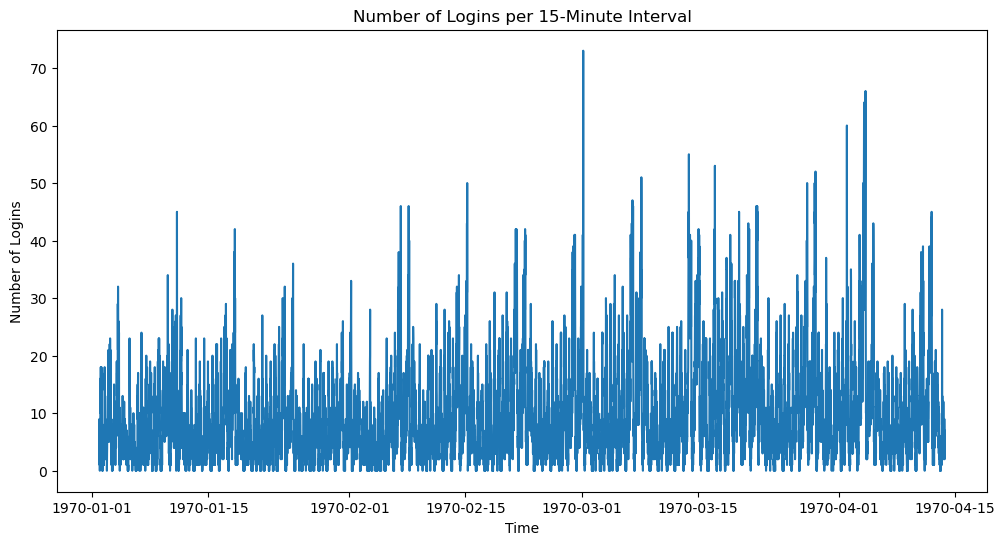

In [6]:
# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(logins_15min.index, logins_15min, label='Logins')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.title('Number of Logins per 15-Minute Interval')
plt.show()

From the graph above, there are no obvious gaps or indications of missing login data. For the time being, I will assume there are no issues with data quality unless further information arises. 

There is one 15 minute period where ~70 logins were recorded, which while uncommon, does not seem unreasonable.

In [7]:
logins_15min['time'] = pd.to_datetime(logins_15min.index)
logins_15min['hour'] = logins_15min['time'].dt.hour
logins_15min['day'] = logins_15min['time'].dt.day
logins_15min['weekday'] = logins_15min['time'].dt.weekday
logins_15min['week'] = logins_15min['time'].dt.isocalendar().week
logins_15min['month'] = logins_15min['time'].dt.month
logins_15min.head()

,count,time,hour,day,weekday,week,month
login_time,,,,,,,
1970-01-01 20:15:00,2,1970-01-01 20:15:00,20,1,3,1,1
1970-01-01 20:30:00,6,1970-01-01 20:30:00,20,1,3,1,1
1970-01-01 20:45:00,9,1970-01-01 20:45:00,20,1,3,1,1
1970-01-01 21:00:00,7,1970-01-01 21:00:00,21,1,3,1,1
1970-01-01 21:15:00,1,1970-01-01 21:15:00,21,1,3,1,1


In [8]:
def graph_grouping(col, labels=None, mean_line=True, alt_ha='left', alt_va='bottom'):
    """
    Graphs the total logins per time grouping.
    """
    # Group by the column and sum the logins
    grouped = logins_15min.groupby(col)['count'].sum()

    # Plot the data and set the labels, if provided
    ax = grouped.plot(kind='bar', title='Total logins per ' + col)
    plt.xticks(rotation=0)
    if labels:
        plt.xticks(range(len(labels)), labels)

    # Add median line, if indicated
    if mean_line:
        median_value = grouped.mean()
        plt.axhline(y=median_value, color='r', linestyle='--', label='mean')
        ax.text(0.5, median_value, f'Mean: {median_value:.2f}', color='r', ha=alt_ha, va=alt_va)

    plt.show()

**Daily Cycles**

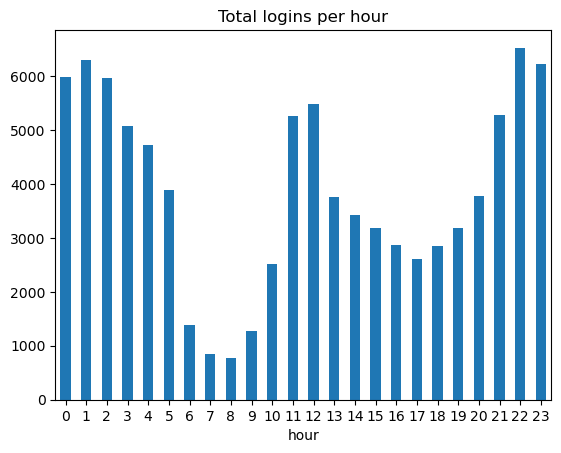

In [9]:
# Graph the total logins per hour
graph_grouping('hour', mean_line=False)


There is a clear pattern of daily login activity. Times of relative low use occurs around 6:00-9:00 and 13:00-20:00, while peak times are 11:00-12:00 and 21:00-2:00. These peak times align with midday and evening/late night. The lowest activity periods are early in the morning, when people may still be asleep. It is important to confirm the timezone for which this data was collected.

**Weekly Cycles**

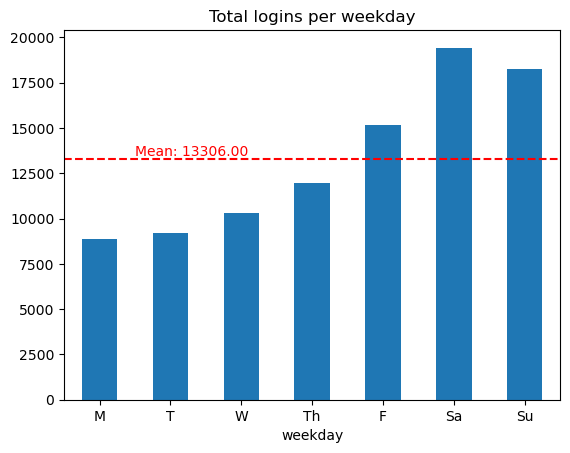

In [10]:
# Graph the total logins per weekday
graph_grouping('weekday', ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])


Users are most active on Friday, Saturday, and Sunday, with these days of the week experience more logins than the average by day of the week. The higher demand on Fridays and weekdends is important to note from a supply and pricing perspective. 

**Trends Over Time**

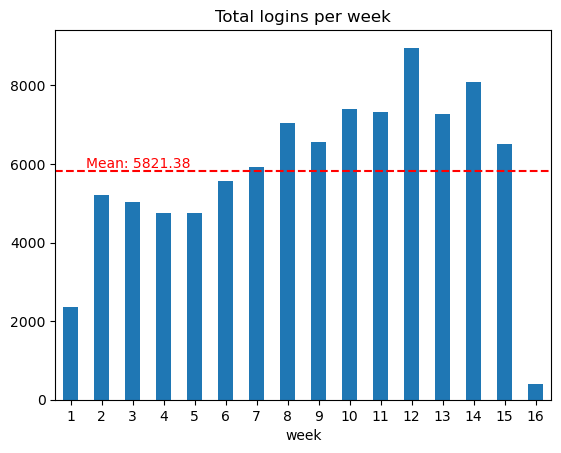

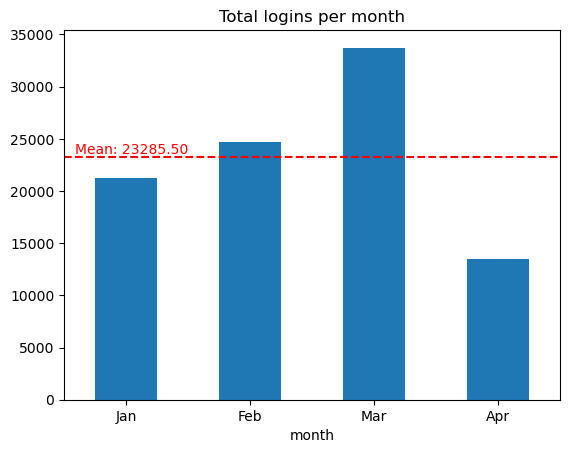

In [11]:
# Graph the total logins per week
graph_grouping('week')

# Graph the total logins per month
graph_grouping('month', ['Jan', 'Feb', 'Mar', 'Apr'], alt_ha='right')


From these weekly and monthly graphs, we can see increased and growing activity. It should be noted that week 16 and April are both incomplete periods, as the data collected stopped part way through the week and month. 

## Part 2: Experiment and Metrics Design


### 2.1. Measure of Success

In order to measure whether the toll reimbursement policy is effective, I would measure the percent increase in number of drivers crossing the bridge. This would capture a baseline of how many drivers cross the toll regardless of reimburesments, as well as the effect of the new policy on their driving patterns. 

### 2.2. Practical Experiment

Our metric of success - increase in bridge crossings - requires data on driving patterns before and after the toll reimburesment policy is in place. I would like to collect **at least** one month of driving data both before and after the policy in order to fully capture weekly driving cycles (weekday versus weekend). If time allows or in conjunction with a longer-term study, a full year's worth of data before and after the policy would capture more nuance and better account for changes in seasonal traffic patterns. 

Once this data is collected, we can calculate the increase in drivers crossing the bridge for our selected time period. A one-sided t-test can be used to indicate whether this increase in bridge crossings is statsistically significant. The resulting p-value from the t-test will tell us the significance: 

- if p-value < 0.05, we can reject the null hypothesis and determine there was a statistically significant change in drivers crossing the bridge after the toll reimburesement policy. 
- if p-value >= 0.05, the increase in drivers crossing the bridge would have occured due to chance, and we cannot determine the impact of the reimbursement policy. 




## Part 3: Predictive Modeling


### Data description

- **city:** city this user signed up in
- **phone:** primary device for this user
- **signup_date:** date of account registration; in the form ‘YYYYMMDD’
- **last_trip_date:** the last time this user completed a trip; in the form ‘YYYYMMDD’
- **avg_dist:** the average distance in miles per trip taken in the first 30 days after signup
- **avg_rating_by_driver:** the rider’s average rating over all of their trips
- **avg_rating_of_driver:** the rider’s average rating of their drivers over all of their trips
- **surge_pct:** the percent of trips taken with surge multiplier > 1
- **avg_surge:** The average surge multiplier over all of this user’s trips
- **trips_in_first_30_days:** the number of trips this user took in the first 30 days after signing up
- **ultimate_black_user:** TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
- **weekday_pct:** the percent of the user’s trips occurring during a weekday

In [12]:
# imports for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                            confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve)

random_seed = 55

### 3.1. Cleaning, EDA, & Visualizations

In [13]:
df = pd.read_json('ultimate_data_challenge.json')

print("Shape of data: ", df.shape)
df.info()

Shape of data:  (50000, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [14]:
# convert the 'signup_date' and 'last_trip_date' columns to datetime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df.dtypes

city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object

In [15]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
trips_in_first_30_days,50000.0,2.2782,0.0,0.0,1.0,3.0,125.0,3.792684
signup_date,50000,2014-01-16 13:04:20.352000,2014-01-01 00:00:00,2014-01-09 00:00:00,2014-01-17 00:00:00,2014-01-24 00:00:00,2014-01-31 00:00:00,NaN
avg_rating_of_driver,41878.0,4.601559,1.0,4.3,4.9,5.0,5.0,0.617338
avg_surge,50000.0,1.074764,1.0,1.0,1.0,1.05,8.0,0.222336
last_trip_date,50000,2014-04-19 08:02:04.992000256,2014-01-01 00:00:00,2014-02-14 00:00:00,2014-05-08 00:00:00,2014-06-18 00:00:00,2014-07-01 00:00:00,NaN
surge_pct,50000.0,8.849536,0.0,0.0,0.0,8.6,100.0,19.958811
weekday_pct,50000.0,60.926084,0.0,33.3,66.7,100.0,100.0,37.081503
avg_dist,50000.0,5.796827,0.0,2.42,3.88,6.94,160.96,5.707357
avg_rating_by_driver,49799.0,4.778158,1.0,4.7,5.0,5.0,5.0,0.446652


#### Null Values

- avg_rating_of_driver
- avg_rating_by_driver

There is no clear indication as to what the missing ratings are meant to represent. Missing rating values will be replaced with the respective medians, which is a better representation of values over the mean since the ratings are highly skewed towards the right. 


- phone

I will replace phone missing values with *Other* since there is no obvious reason why these values are missing or how to impute the value. 

Text(0.5, 0, 'Rating')

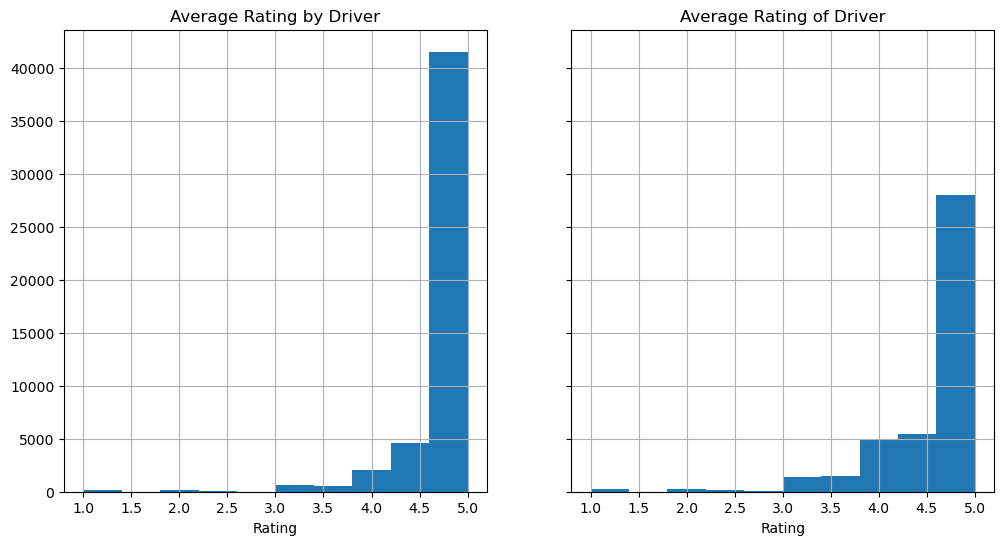

In [16]:
# Visualize the distribution of the ratings 
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(12,6))

plt.subplot(1, 2, 1)
df['avg_rating_by_driver'].hist()
plt.title('Average Rating by Driver')
plt.xlabel('Rating')

plt.subplot(1, 2, 2)
df['avg_rating_of_driver'].hist()
plt.title('Average Rating of Driver')
plt.xlabel('Rating')

In [17]:
# fill missing values with zero
df['avg_rating_by_driver'] = df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].median())
df['avg_rating_of_driver'] = df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].median())
df.isnull().sum()

city                        0
trips_in_first_30_days      0
signup_date                 0
avg_rating_of_driver        0
avg_surge                   0
last_trip_date              0
phone                     396
surge_pct                   0
ultimate_black_user         0
weekday_pct                 0
avg_dist                    0
avg_rating_by_driver        0
dtype: int64

In [18]:
# Propotion of phone values
phone_counts = df['phone'].value_counts(normalize=True)
print(phone_counts)

phone
iPhone     0.697162
Android    0.302838
Name: proportion, dtype: float64


In [19]:
df['phone'] = df['phone'].fillna('Other')
df['phone'].value_counts(normalize=True)

phone
iPhone     0.69164
Android    0.30044
Other      0.00792
Name: proportion, dtype: float64

#### Retention Metric

For these users who signed up for an Ultimate account in January 2014, they are cagegorized as retained if they've used their Ultimate account in the last 30 days. The most recent *last_trip_date* is 01 July 2014, so a customer is retained if the *last_trip_date* is greater than 01 June 2014. 

The newly created *retained* dummy variable is 1 if the customer is retained, and 0 if not. 

In [20]:
# create retention metric
retention_date = max(df['last_trip_date']) - pd.Timedelta(days=30)
df['retained'] = (df['last_trip_date'] > retention_date).astype(int)
retained_propotion = df['retained'].value_counts(normalize=True)

print(df[['retained', 'last_trip_date']].head(), "\n")
print(retained_propotion)

   retained last_trip_date
0         1     2014-06-17
1         0     2014-05-05
2         0     2014-01-07
3         1     2014-06-29
4         0     2014-03-15 

retained
0    0.6338
1    0.3662
Name: proportion, dtype: float64


**From the January cohort, 36.62% of users were retained.**

#### EDA - Categorical Variables

Text(0.5, 1.0, 'Proportion by Phone Values')

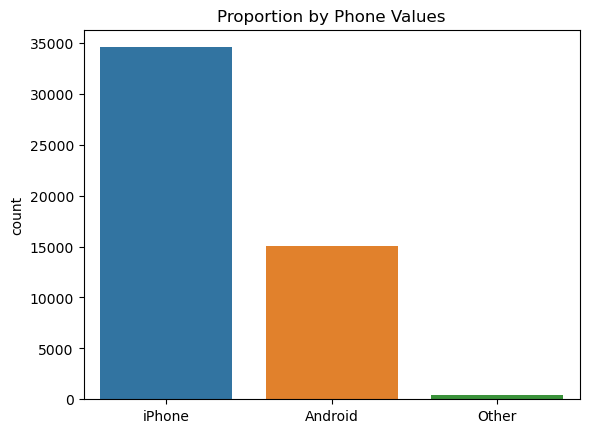

In [21]:
sns.barplot(x=df['phone'].unique(), y=df['phone'].value_counts(dropna=False), hue=df['phone'].unique())
plt.title('Proportion by Phone Values')

Text(0.5, 1.0, 'Proportion by City Values')

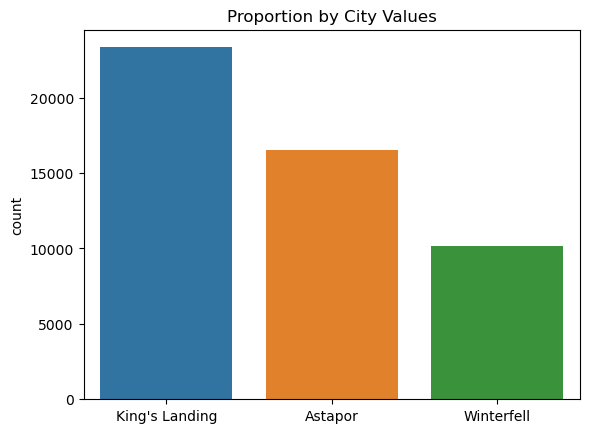

In [22]:
sns.barplot(x=df['city'].unique(), y=df['city'].value_counts(dropna=False), hue=df['city'].unique())
plt.title('Proportion by City Values')

Text(0.5, 1.0, 'Proportion Ultimate Black Users')

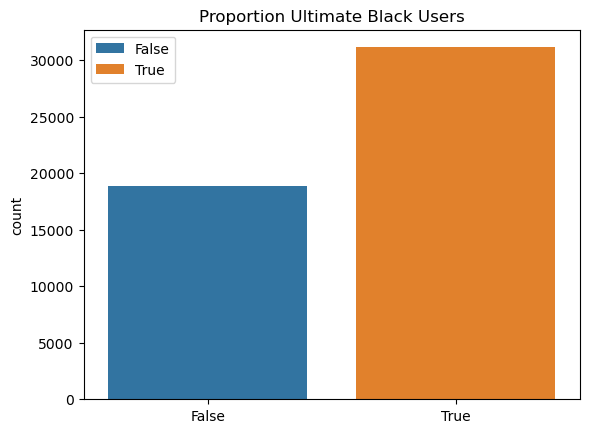

In [23]:
sns.barplot(x=(df['ultimate_black_user'].unique()), y=df['ultimate_black_user'].value_counts(), hue=df['ultimate_black_user'].unique())
plt.title('Proportion Ultimate Black Users')

#### EDA - Numeric Variables

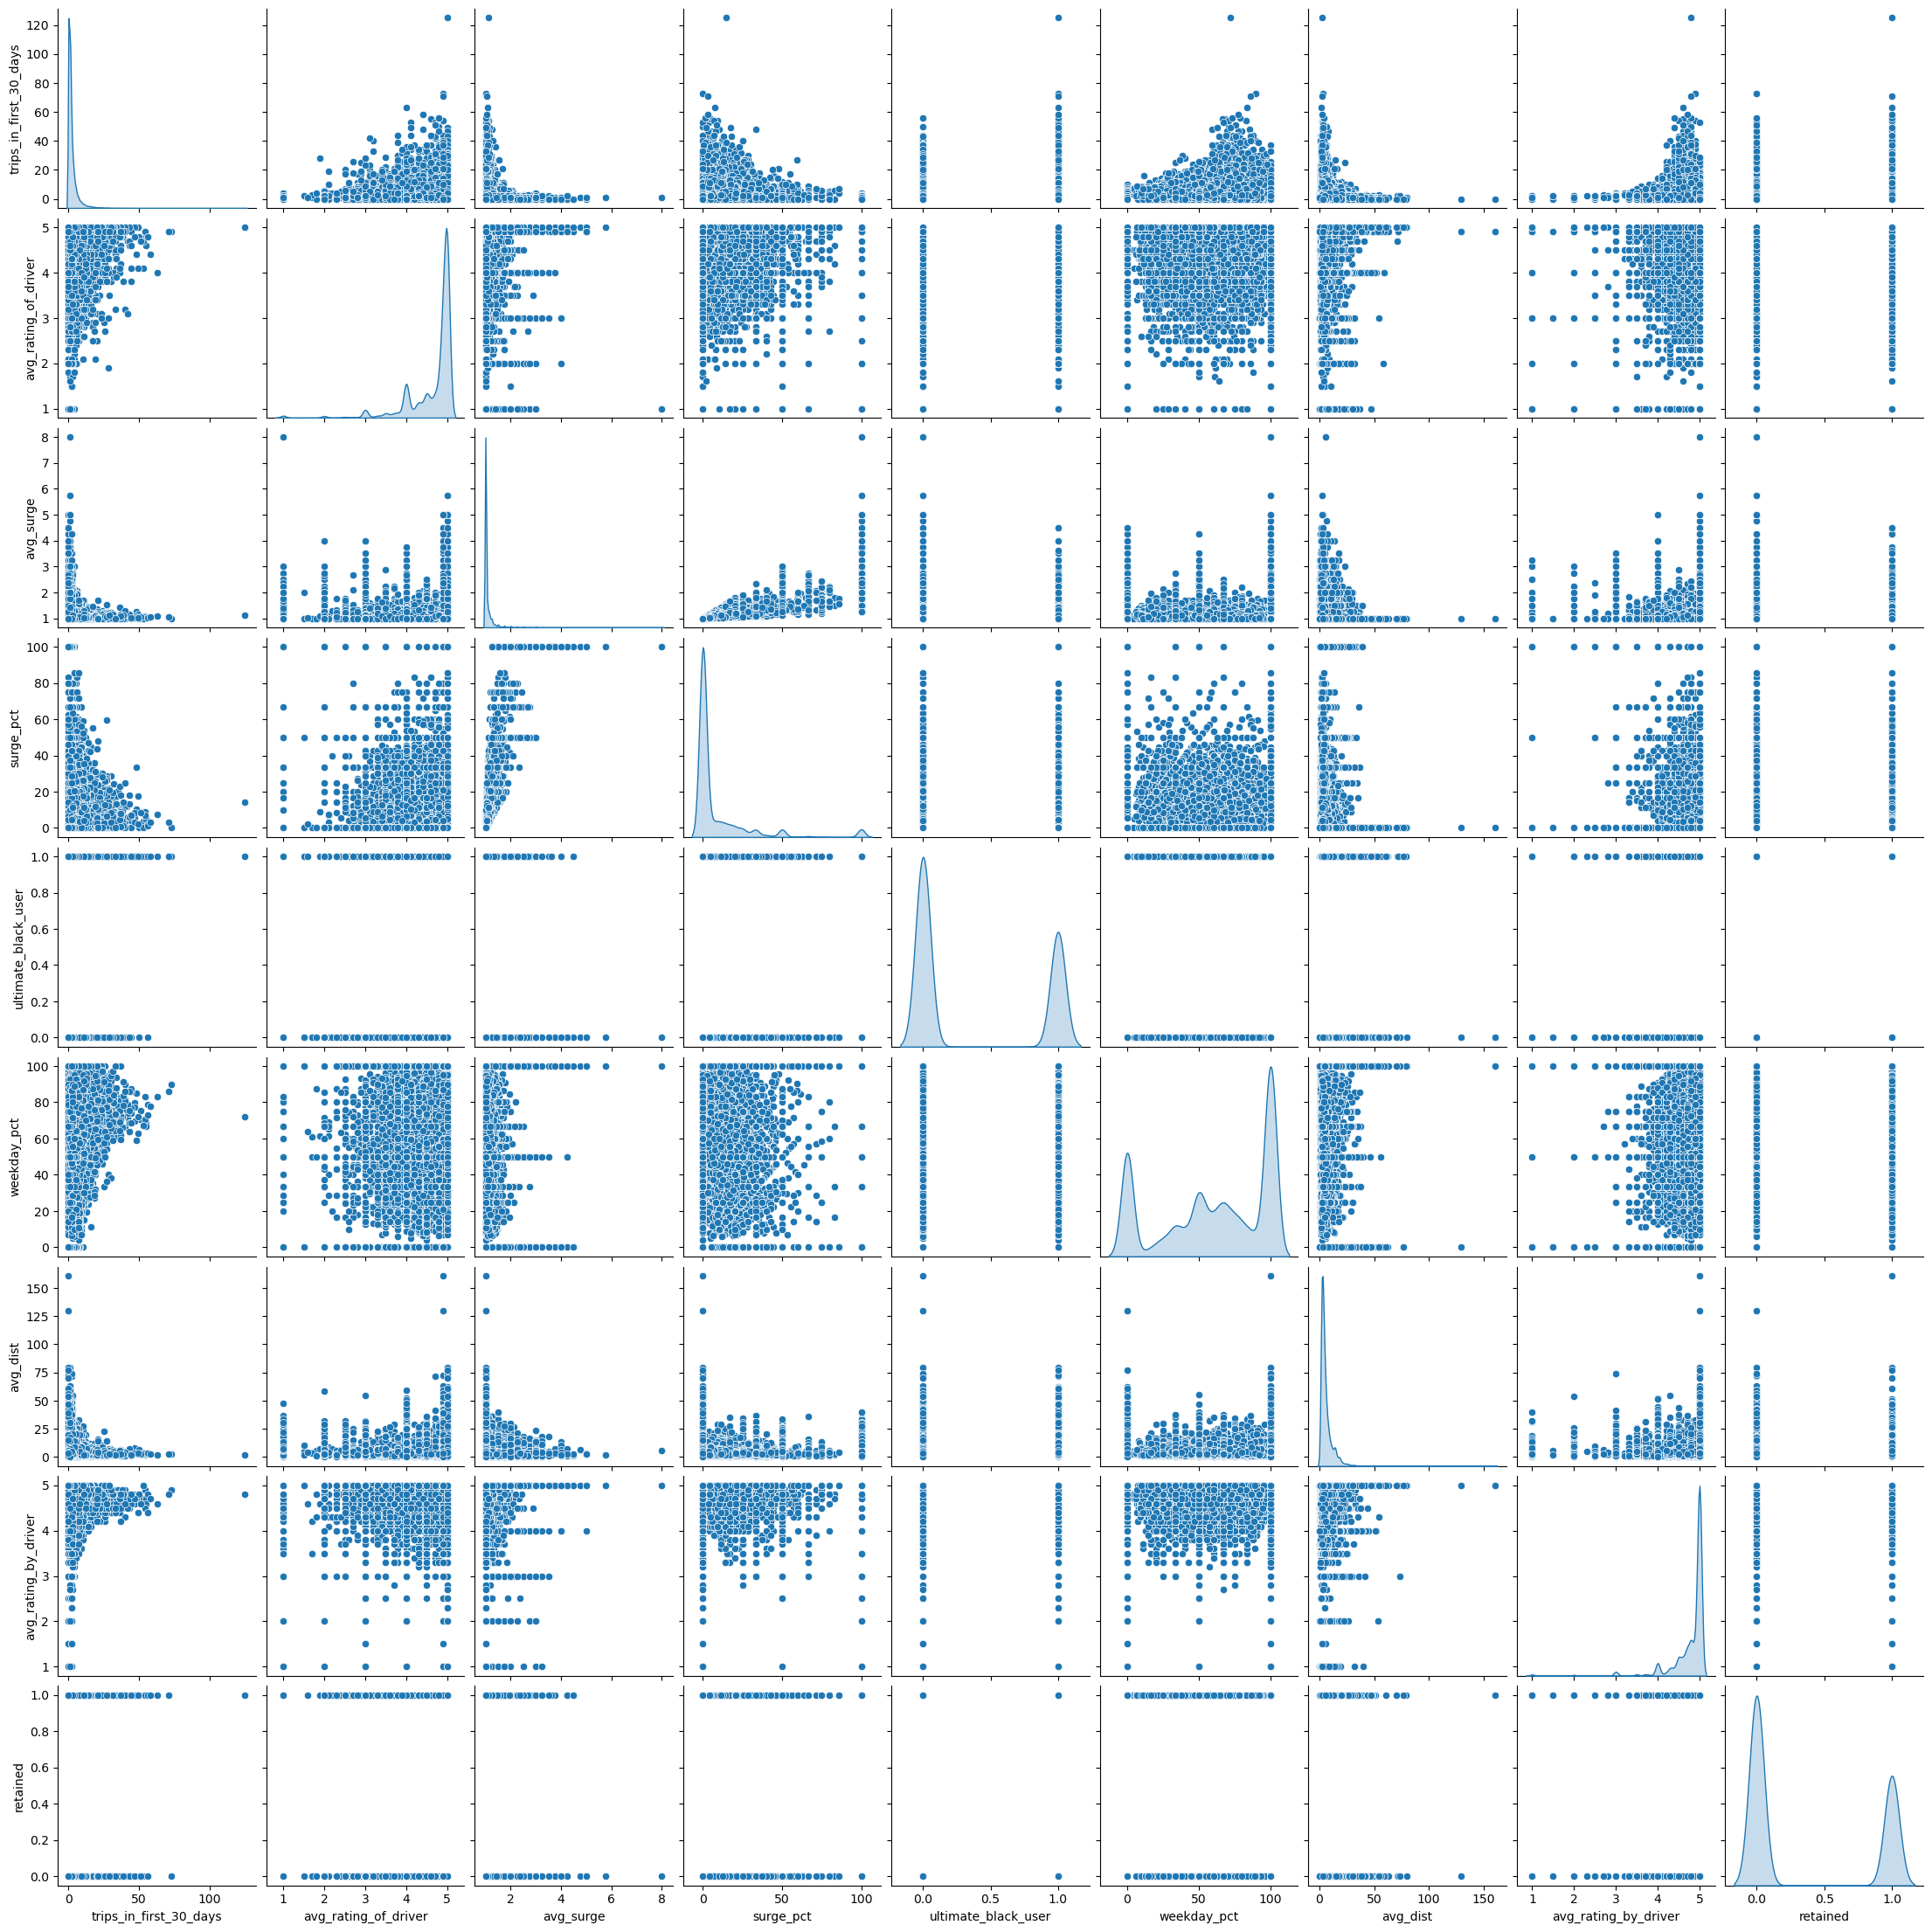

In [24]:
sns.pairplot(df, diag_kind='kde')

<Axes: >

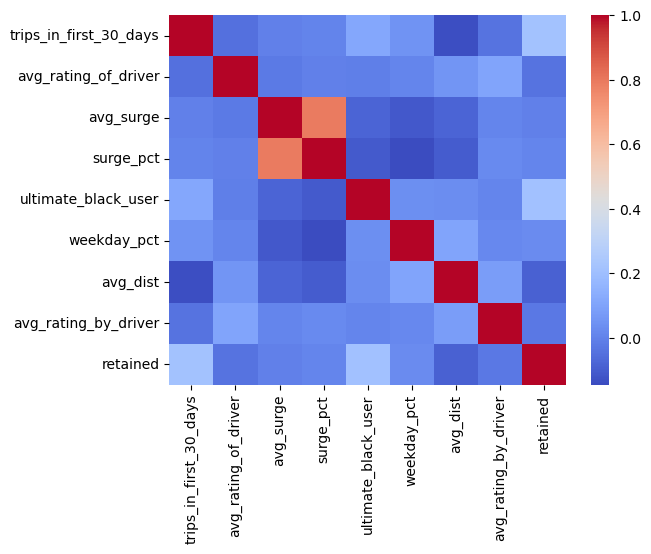

In [25]:
sns.heatmap(df.corr(numeric_only=True), cmap='coolwarm')

There appears to be correlation between 'surge_pct' and 'avg_surge'. In order to maintain independence within the features, I will drop 'avg_surge'. 

### 3.2. Predictive Model
 

#### Preprocessing

In [26]:
# on-hot encode the categorical variables: city & phone
df_clean = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)

# convert booleans to integer
for col in df_clean.columns:
    if df_clean[col].dtype == 'bool':
        df_clean[col] = df_clean[col].astype(int)

In [27]:
y = df_clean['retained']
X = df_clean.drop(columns=['retained', 'signup_date', 'last_trip_date', 'avg_surge'])
X_scaled = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y, test_size=0.2, random_state=random_seed)


#### Initial Models

- LogisticRegression
- DecisionTreeClassifier
- RandomForestRegressor

In [28]:
def confusion_matrix_graph(clf, X_test=X_test, y_test=y_test):

    # calculate the confusion matrix
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title('Confusion Matrix')
    plt.show()


def auc_graph(clf, X_test=X_test, y_test=y_test):
    # Create a DataFrame to store the results of the models
    results = pd.DataFrame(columns=['Model', 'AUC'])

    # calculate AUC score
    auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    print(f"AUC Score: {auc_score:.4f}")

    # Plot the results
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()



Average CV Score: 0.7274


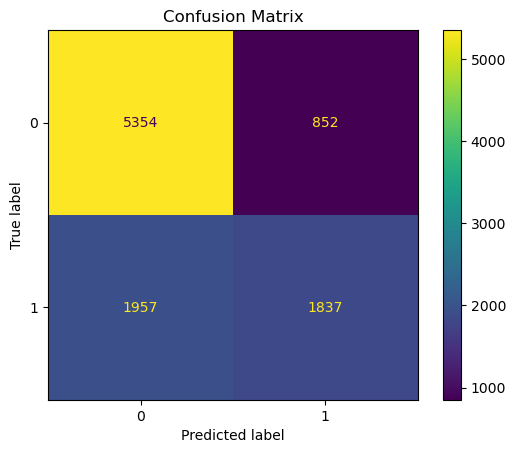

AUC Score: 0.7676


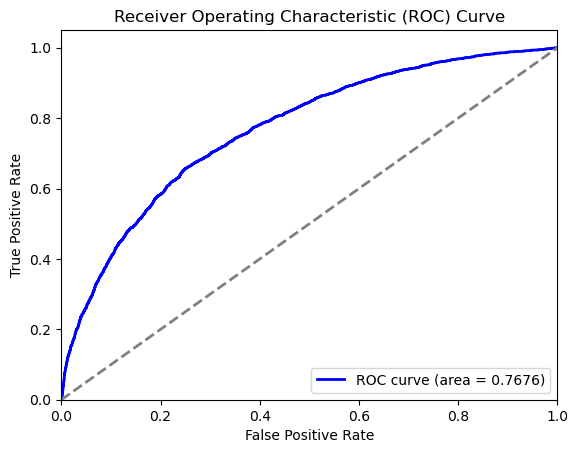

In [29]:
# Logistic Regression
log_reg = LogisticRegression()

# cross validation
cv_scores = cross_val_score(log_reg, X_train_sc, y_train_sc, cv=5)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

# fit and predict the model for confusion matrix
log_reg.fit(X_train_sc, y_train_sc)
confusion_matrix_graph(log_reg, X_test=X_test_sc, y_test=y_test_sc)

# AUC graph
auc_graph(log_reg, X_test=X_test_sc, y_test=y_test_sc)


Logistic regressions recall is less than 50%, i.e. fails to correctly label retained customers more than half the time.

Average CV Score: 0.7126


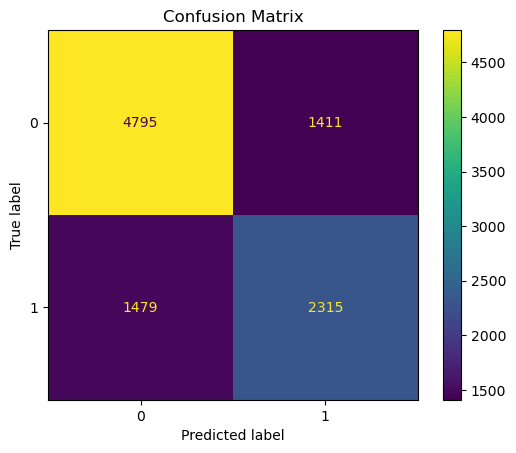

AUC Score: 0.6917


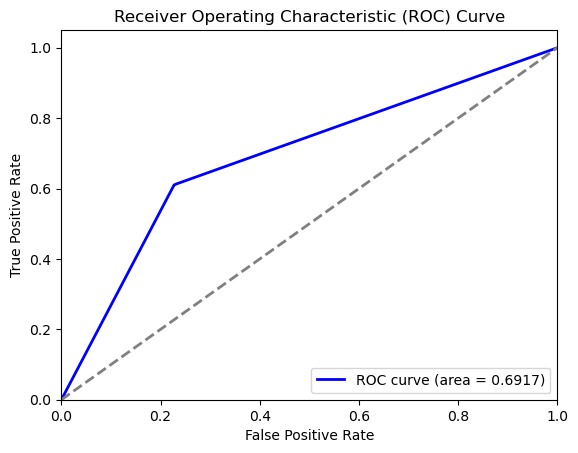

In [30]:
# Decision Tree
dt = DecisionTreeClassifier()

# cross validation
cv_scores = cross_val_score(dt, X_train, y_train, cv=5)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

# fit and predict the model for confusion matrix
dt.fit(X_train, y_train)
confusion_matrix_graph(dt)

# AUC graph
auc_graph(dt)

Average CV Score: 0.7639


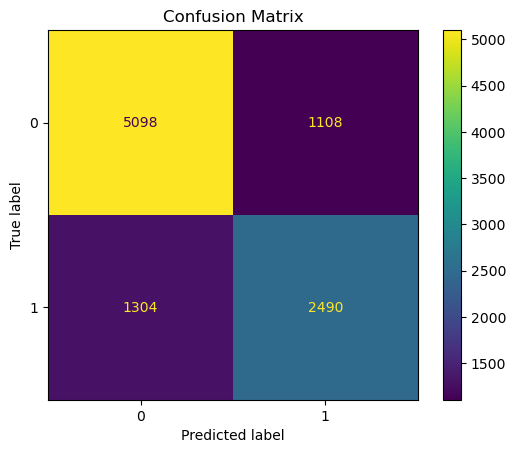

AUC Score: 0.8244


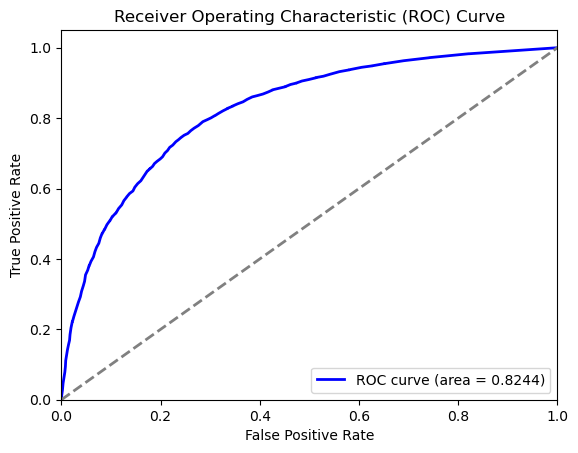

In [31]:
# Random Forest
rf = RandomForestClassifier()

# cross validation
cv_scores = cross_val_score(rf, X_train, y_train, cv=5)
print(f"Average CV Score: {np.mean(cv_scores):.4f}")

# fit and predict the model for confusion matrix
rf.fit(X_train, y_train)
confusion_matrix_graph(rf)

# AUC graph
auc_graph(rf)

Random Forest performs the best in predicting retention, and will therefore be moving forward with into hyperparameter tuning and feature selection. 

#### Hyperparameter Tuning & Features

In [32]:
param_grid = {'n_estimators':[50, 100, 150],
             'criterion':['gini', 'entropy'], 
             'max_depth':[3, 5, 10, None], 
             'min_samples_split':[2, 5, 10]}

rf = RandomForestClassifier()
rf_cv = GridSearchCV(rf, param_grid, cv=5)
rf_cv.fit(X_train, y_train)
print("Tuned Random Forest Parameters: {}".format(rf_cv.best_params_))
print("Best score is {}".format(rf_cv.best_score_))

Tuned Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 150}
Best score is 0.7903


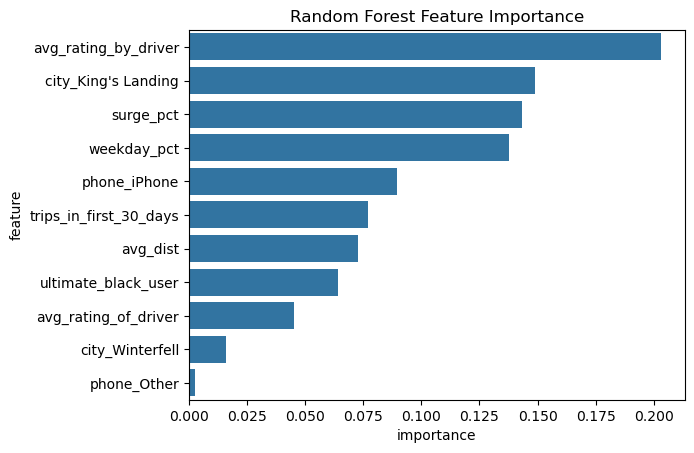

In [33]:
rf_tuned = RandomForestClassifier(**rf_cv.best_params_)
rf_tuned.fit(X_train, y_train)

importance = pd.DataFrame(rf_tuned.feature_importances_, columns=['importance'])
importance['feature'] = X_train.columns

sns.barplot(data=importance.sort_values(by='importance', ascending=False),
            y='feature', x='importance')
plt.title('Random Forest Feature Importance')
plt.show()

AUC Score: 0.8538


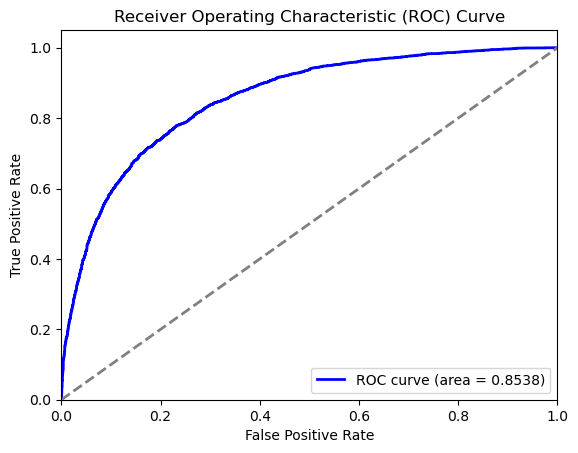

In [34]:
auc_graph(rf_tuned)

**Final model:** random forest classifier

- **Accuracy score:** 0.79
- **AUC score:** 0.85


Since this problem is a binary classification question, decision trees and logistic regression are good approaches to start. Additionally, random forest model also reduceds the risk of overfitting that is present with single decision trees. The inital run of these three models showed random forest with the best accuracy and AUC scores, which led me to move forward to hyperparameter tuning with this model. After fine tuning, both the accuracy and AUC improved by 0.03. 

### 3.3. Discuss Results

The most important feature of the model to predictic retention is **avg_rating_by_driver**, followed by city_King's_Landing, surge_pct, and weekday_pct. With this information, Ultimate can focus it's effort on these factors to imporve customer retention: 

- avg_rating_by_driver: good experiences and generous drivers has a positive impact. 
- city_King's_Landing: this city is mroe likely to remain with Ultimate. 
- surge_pct: large percentages of surge pricing could be driving customers away. 
- weekday_pct: users taking trips during the week are more reliant on Ultimate's services, and therefore are more likely to stay. 

